<a href="https://colab.research.google.com/github/tomatencode/Mausefalle/blob/main/mausefalle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mausefalle**

In [2]:
from math import *
import scipy
import matplotlib.pyplot as plt
import numpy as np

In [3]:
u = 50 #[-] Verhältnis von Drehmoment der Feder zu Drehmoment der Achse
rr = 0.1 #[m] radius des antriebsreifen
m = 0.1 #[kg] masse des autos

friction = True
max_sim_length = 60 #[s] maximum simulation length

tolleranz = 0.05 # erlaubte abweichung des energie erhaltungs Satzes

defenirt eigenschaften für auto und simulation

In [4]:
def find_Fr(v):

    return v / 20 # Wiederstand in [N] (Schätzwert)

In [5]:
def find_Ff(phi):

    if phi < pi:
        return 2 # Kraft der Feder in [Nm] (Schätzwert)
    else:
        return 0 # Kraft der Feder in [Nm]

Benutzerdefinirte Funktionen zur berechnung von Federkraft und Reibung.

In [6]:
def find_phi(x,rr,u):

    ur = 2 * pi * rr # ur[m] = 2pi[-] * rr[m]
    phi = x / ( ur * u ) # phi[-] = x[m] / (ur[m] * u[-])
    phi_rad = 2 * pi * phi # phi_rad[rad] = 2pi[-] * phi[-]

    return phi_rad # [rad]

find_phi findet den Winkel der Mausefalle in radien.
Dafür berechnet sie den umfang des Rades $ur$ mit dem radius $rr$:

$ur = 2π \cdot rr$

dann berechnet sie die umdrehungen der falle $φ$ mit der zurückgelegten Strecke $x$ und der Getriebeübersetztung $u$:

$φ = \frac{x}{ur \cdot u}$

die umrehungen weden dann in Radien umgerechnet:

$φ_{rad} = 2π \cdot φ$

In [7]:
def find_Fa(rr,u,phi):

    Ma = find_Ff(phi) # Ma[Nm] = Ff(phi[rad])[Nm]
    Me = Ma / u # Me[Nm] = Ma / ü[-]
    Fa = Me / rr # Fa[Nm] = Me[Nm] / rr[m]

    return Fa # [N]

find_Fa findet die beschleunigungskraft des Autos $F_a$.
dafur berechnet es das Drehmoment der mausefalle $M_a$ mit:

$M_a = F_f(φ)$

dann findet sie das Drehmoment der Achse $M_e$ mit der Getriebeübersetztung $u$:

$M_e = \frac{M_a}{u}$

anschließend renchnet die Funktion $M_e$ in $F_a$ mit dem Radius der Reifen $rr$ um:

$F_a = \frac{M_e}{rr}$

In [8]:
def f(t, y):

    [v,x] = y

    return [ (find_Fa(rr,u,find_phi(x,rr,u)) - find_Fr(v))/m, v]


In [9]:
def fnofric(t, y):

    [v,x] = y

    return [ find_Fa(rr,u,find_phi(x,rr,u))/m, v]

$f(t, v, x)$ ist die differenzialgleichung mit der position und Geschwindigkeit des autos berechnet werden.

$\frac{dv}{dt} = F_a - F_r$

$\frac{dx}{dt} = v$

$f_{no fric}(t, v,x)$ berechnet das selbe bei vernachlässigung der Reibung.

In [10]:
def solve_ivp(max_sim_length,friction):

    if friction == True:
        solution = scipy.integrate.solve_ivp(f, [0, max_sim_length], [0,0], method = "Radau", dense_output=True)
    else:
        solution = scipy.integrate.solve_ivp(fnofric, [0, max_sim_length], [0,0], method = "Radau", dense_output=True)
    return solution

Löst die differenzialgleichung mit oder ohne reidung ($\text{fric}$) für eine bestimmte zeit ($\text{max sim length}$) mit scipy.

In [11]:
def find_simulation_lenght(max_lenght,sulution,rr,u,v_min):

    for s in range(0,max_lenght):
        x = sulution.sol(s)[1]
        v = sulution.sol(s)[0]
        phi = find_phi(x,rr,u)
        if phi > pi and v < v_min:
            return s

    return max_lenght

findet passende simulationslänge.

Returnd wenn $v < \text{v_min}$ und $φ > π.$

In [12]:
def find_Wmf(M, phi):

    Wmf = M * phi # e[J] = M[Nm] * phi[rad]

    return Wmf #[J]

um zu testen ob der Energieerhaltungssatzt verletzt wurde findet $W_{mf}(M, φ)$ die arbeit die von der mausefalle verrichtet wurde mit dem Drehmoment $M$ und dem winkel $φ$ mit der Formel:

$W_{mf} = M \cdot φ$

(diese formel funktionirt nur für eine statische federkraft)

In [13]:
def find_Wacc(m,ve,va):

    Wacc = (1/2) * m * ve**2 - (1/2) * m * va**2 # Wacc[J] = 1/2m[kg]ve[m/s]² - 1/2m[kg]va[m/s]²

    return Wacc #[J]

um zu testen ob der Energieerhaltungssatzt verletzt wurde findet $W_{acc}(m, v_e, v_a)$ die Beschleunigungsarbeit des autos mit der anfangsgeschwindigkeit $v_a$, der Endgeschwindigkeit $v_e$ und der Masse $m$, diese wird berechnet mit der Formel:

$W_{acc} = \frac{1}{2}m \cdot v_e - \frac{1}{2}m \cdot v_a$

In [14]:
def test(do_print):
    solution = solve_ivp(max_sim_length,False)
    ve = solution.sol(max_sim_length)[0]
    va = solution.sol(0)[0]

    Wmf = find_Wmf(2,pi)
    Wacc = find_Wacc(m,ve,va)
    abweichung = abs(Wmf - Wacc)

    print("Emf = "+str(Wmf) + " J und Eacc = " + str(Wacc)+ " J")

    if do_print:
        if abweichung < tolleranz:
            print("kein bug! abweichung: " + str(abweichung) + " J")
        else:
            print("abweichung über tolleranz! abweichung: " + str(abweichung) + " J")
    return abweichung

prüft ob der Energieerhaltungssatzt verletzt wurde indem sie die arbeit der feder und die der beschleunigung vergleicht.

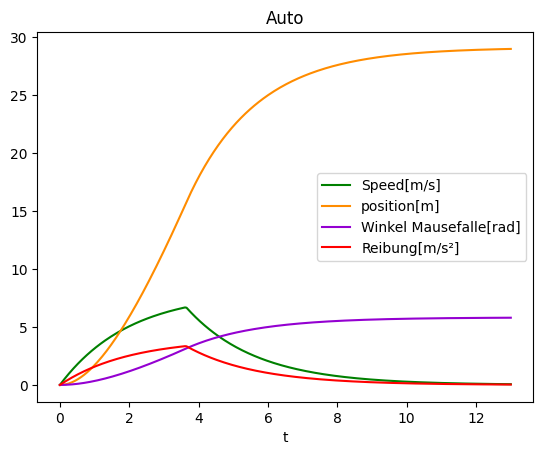

Emf = 6.283185307179586 J und Eacc = 6.297916582610997 J
kein bug! abweichung: 0.014731275431410396 J


0.014731275431410396

In [18]:
solution = solve_ivp(max_sim_length,friction) # lösung der differenzialgleichung [-]

s = find_simulation_lenght(max_sim_length,solution,rr,u,0.1) # passende länge der simulation [s]

t = np.linspace(0, s, 300) # vektor von 300 zeitpunkten von 0 bis s [s]

plt.plot(t, solution.sol(t)[0].T,label='Speed[m/s]',color="green")
plt.plot(t, solution.sol(t)[1].T,label='position[m]',color=(1,0.55,0))
plt.plot(t, find_phi(solution.sol(t)[1],rr,u).T,label='Winkel Mausefalle[rad]',color=(0.58,0,0.82))
if friction == True:
    plt.plot(t, (find_Fr(solution.sol(t)[0])/m).T,label='Reibung[m/s²]',color="red")

plt.xlabel('t')
plt.legend()
plt.title('Auto')

plt.show()
test(True) # testet ob der energieerhaltungs satz verletzt wurde

plotet Geschwindigkeit Position Reibung und Winkel der Mausefalle.